In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

#Google drive에서 파일을 받아오기 위해 선언된 코드

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
trainPath = "./train"
valPath = "./val"

#Train 파일과 val 파일의 경로를 저장한 코드

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# 쓸만한 transformation 방법들
# 1. 평행 이동
# 2. 회전
# 3. 닮음 변환
# 4. 아핀 변환 -> 크기 변경, 평행이동, 회전 다 쓸 수 있는 아핀을 쓰자!

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)), #입력 크기 resize
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Set to 0 to deactivate rotations. scale is randomly sampled from the range 0.8 <= scale <= 1.2, 평행성을 보존하면서 변환
        transforms.RandomHorizontalFlip(), #이미지를 무작위로 수평 뒤집기를 한다
        transforms.ToTensor(), #텐서로 바꿔줌
        normalize #주어진 평균과 표준편차를 사용하여 정규화
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)), #입력 크기 resize
        transforms.ToTensor(), #텐서로 바꿔줌
        normalize #주어진 평균과 표준편차를 사용하여 정규화
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(trainPath, data_transforms['train']), 
    'val': 
    datasets.ImageFolder(valPath, data_transforms['val'])
} #transform 옵션을 넣어서 이미지를 불러옵니다

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,   # 배치사이즈는 64와 32의 성능 차이가 거의 없었다
                                shuffle=True,    # 트레이닝이기 때문에 셔플 해야합니다
                                num_workers=0),  # 스레드 갯수
    'val':
    torch.utils.data.DataLoader(image_datasets['val'],
                                batch_size=32,
                                shuffle=False,  # 테스트는 셔플할 필요 없습니다
                                num_workers=0)  # 스레드 갯수
}

print(len(dataloaders['train'].dataset))
print(len(dataloaders['val'].dataset))
print(len(image_datasets['val'].classes))
print(len(image_datasets['train'].classes))

19639
2799
35
35


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

#gpu를 사용하기 위해 cuda 설정

device(type='cpu')

In [5]:
#from .utils import load_state_dict_from_url
from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152',]


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)




In [6]:
model = resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 35)).to(device)
print(model)

# 트레이닝과 테스트에 사용할 모델을 정의합니다
# 마지막에 fc layer를 2개 넣어줬습니다

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

#criterion과 optimizer를 설정해줍니다

In [8]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']: #trainign, val 순으로 phase에 들어갑니다
            if phase == 'train': #트레이닝 데이터일 경우
                model.train()
            else:               # else는 validation 데이터일 경우입니다
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  #input은 image를 뜻합니다. gpu를 사용할 수 있도록 cuda로 바꿔 넣어줍니다
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':  #training 모드에서는 weight를 학습하고 update합니다
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)  #마지막 layer에서 가장 값이 큰 클래스를 예측 값으로 지정해줍니다
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [36]:
model_trained = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
train loss: 0.2541, acc: 0.9181
val loss: 0.2706, acc: 0.9150
Epoch 2/5
----------
train loss: 0.2398, acc: 0.9212
val loss: 0.2500, acc: 0.9214
Epoch 3/5
----------
train loss: 0.2332, acc: 0.9227
val loss: 0.2470, acc: 0.9235
Epoch 4/5
----------
train loss: 0.2292, acc: 0.9257
val loss: 0.2379, acc: 0.9268
Epoch 5/5
----------
train loss: 0.2274, acc: 0.9260
val loss: 0.2567, acc: 0.9232


In [0]:
torch.save(model_trained.state_dict(), '/gdrive/My Drive/final/resnet50_weights_10_9232_ver7.pth') #학습한 weight를 저장합니다

In [39]:
model = models.resnet50(pretrained=False).to(device) #test를 위해 모델을 불러옵니다. 
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 35)).to(device)
model.load_state_dict(torch.load('./resnet50_weights_35_9285_ver3.pth')) #저장된 weight를 불러옵니다

<All keys matched successfully>

In [0]:
data_transforms2 = {
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets2 = {
    'val': 
    datasets.ImageFolder(valPath, data_transforms['val'])
}

dataloaders2 = {
    'val':
    torch.utils.data.DataLoader(image_datasets['val'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  
}

#앞에 설명된 코드입니다.

In [41]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
acc = 0.
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in dataloaders2['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim = -1)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        acc += torch.sum(predicted == labels).item()

print('*'*20, 'Test', '*'*20)
print('Loss: {}, Accuracy: {} %'.format(loss.item(), acc/len(image_datasets2['val'])*100))
print('*'*46)
print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

******************** Test ********************
Loss: 0.03698677197098732, Accuracy: 92.85459092533047 %
**********************************************
Test Accuracy of the model on the 2799 test images: 92.85459092533047 %


In [0]:
validation_img_paths = ["/amphibian/n02704792_3830.jpg",
                        "/camera/image_0009.jpg",
                        "/camera/image_0003.jpg",
                        "/camera/image_0034.jpg",
                        "/daisy/163978992_8128b49d3e_n.jpg",
                        "/dumplings/138090.jpg",
                        "/pad_thai/600929.jpg",
                        "/sunflower/4831577091_f56157a5d5_n.jpg",
                        ]
img_list = [Image.open(valPath + img_path) for img_path in validation_img_paths]

#validation에 있는 특정 이미지의 정확도(label과의 일치도)를 알고 싶을 때, 그 파일의 위치를 test_img_path에 넣어줍니다. 

In [0]:
validation_batch = torch.stack([data_transforms['val'](img).to(device) for img in img_list])

In [19]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[1.00000000e+00, 8.38569123e-13, 4.87688449e-12, 2.92347535e-11,
        2.18351073e-10, 3.78697236e-13, 4.55371790e-14, 6.93209812e-12,
        3.63935791e-11, 1.16997561e-14, 2.29694902e-10, 4.61038869e-16,
        1.14527791e-14, 2.39186809e-10, 7.57740171e-13, 5.05176526e-11,
        1.66856650e-11, 2.26120094e-13, 4.58872222e-15, 2.84022768e-15,
        1.52511684e-12, 3.38773639e-14, 7.63396724e-12, 3.25587018e-12,
        2.02522354e-09, 1.00578439e-15, 1.44492978e-08, 1.46434807e-12,
        7.84819563e-15, 6.14755247e-10, 2.18937733e-11, 7.23687745e-17,
        1.05711412e-10, 2.18945523e-16, 6.81129236e-17],
       [3.63179396e-07, 2.22344632e-09, 4.77150657e-08, 1.29540183e-07,
        9.99962091e-01, 8.70706909e-11, 7.36737268e-11, 3.22943734e-08,
        2.27913887e-07, 3.61983447e-12, 1.22716031e-07, 3.11037311e-08,
        3.13999379e-07, 1.14287255e-08, 4.35811558e-07, 6.27070715e-13,
        1.02537433e-06, 1.02786890e-10, 4.61080812e-10, 3.20613913e-12,
       

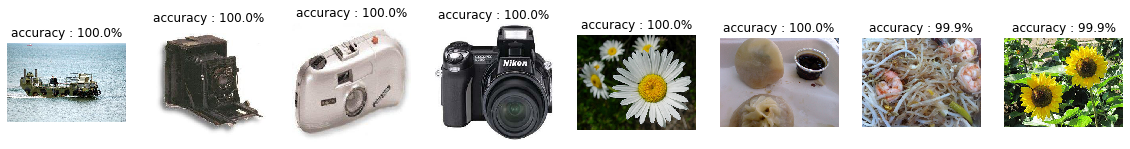

In [21]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    for j in pred_probs[i, 0: ] :
      if(j*100 > 50) :
        ax.set_title("accuracy : {:.1f}%".format(j*100))
    ax.imshow(img)

# 입력한 이미지에 대한 정확도가 나옵니다 